In [1]:
%matplotlib inline
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res
from utils import *

W0725 19:03:53.776204 139640482948928 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0725 19:03:54.200688 139640482948928 deprecation_wrapper.py:119] From /home/yl238/projects/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/ipynb/utils.py:114: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0725 19:03:54.201493 139640482948928 deprecation_wrapper.py:119] From /home/yl238/projects/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/ipynb/utils.py:119: The name tf.InteractiveSession is deprecated. Please use tf.compat.v1.InteractiveSession instead.



## A little more on TensorFlow and TensorFlow Probability
To explain TensorFlow Probability, it's worth going into the various methods of working with Tensorflow tensors. Here, we introduce the notion of Tensorflow graphs and how we can use certain coding patterns to make our tensor-processing workflows much faster and more elegant.

## TensorFlow Graph and Eager Modes
TFP accomplishes most of its heavy lifting via the main `tensorflow` library. The `tensorflow` library also contains many of the familiar computational elements of NumPy and uses similar notation. While NumPy directly executes computations (e.g. when you run a + b), `tensorflow` in graph mode instead builds up a "compute graph" that tracks that you want to perform the + operation on the elements a and b. Only when you evaluate a tensorflow expression does the computation take place--`tensorflow` is lazy evaluated. The benefit of using Tensorflow over NumPy is that the graph enables mathematical optimizations (e.g. simplifications), gradient calculations via automatic differentiation, compiling the entire graph to C to run at machine speed, and also compiling it to run on a GPU or TPU.

Fundamentally, TensorFlow uses graphs for computation, wherein the graphs represent computation as dependencies among individual operations. In the programming paradigm for Tensorflow graphs, we first define the dataflow graph, and then create a TensorFlow session to run parts of the graph. A Tensorflow `tf.Session()` object runs the graph to get the variables we want to model. In the example below, we are using a global session object `sess`, which we created above in the "Imports and Global Variables" section.

To avoid the sometimes confusing aspects of lazy evaluation, Tensorflow's eager mode does immediate evaluation of results to give an even more similar feel to working with NumPy. With Tensorflow eager mode, you can evaluate operations immediately, without explicitly building graphs: operations return concrete values instead of constructing a computational graph to run later. If we're in eager mode, we are presented with tensors that can be converted to NumPy array equivalents immediately. Eager mode makes it easy to get started with TensorFlow and debug models.

TFP is essentially:

* a collection of tensorflow symbolic expressions for various probability distributions that are combined into one big compute graph, and
* a collection of inference algorithms that use that graph to compute probabilities and gradients.

For practical purposes, what this means is that in order to build certain models we sometimes have to use core Tensorflow. This simple example for Poisson sampling is how we might work with both graph and eager modes:

In [4]:
parameter = tfd.Exponential(rate=1., name='poisson_param').sample()
rv_data_generator = tfd.Poisson(parameter, name='data_generator')
data_generator = rv_data_generator.sample()

if tf.executing_eagerly():
    data_generator_ = tf.contrib.framework.nest.pack_sequence_as(
        data_generator,
        [t.numpy() if tf.contrib.framework.is_tensor(t) else t
        for t in tf.contrib.framework.nest.flatten(data_generator)])
else:
    data_generator_ = sess.run(data_generator)
    
print("Value of sample from data generator random variable:", data_generator_)

Value of sample from data generator random variable: 1.0


## Example: Bayesian A/B testing
A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A vs drug B. The company will test drug A on some fraction of their trials, and drug B on the other fraction (this fraction is often 1/2, but we will relax this assumption). After performing enough trials, the in-house statisticians sift through the data to determine which drug yielded better results.

Similarly, front-end web developers are interested in which design of their website yields more sales or some other metric of interest. They will route some fraction of visitors to site A, and the other fraction to site B, and record if the visit yielded a sale or not. The data is recorded (in real-time), and analyzed afterwards.

Often, the post-experiment analysis is done using something called a hypothesis test like *difference of means test* or *difference of proportions test*. This involves often misunderstood quantities like a "Z-score" and even more confusing "p-values" (please don't ask). If you have taken a statistics course, you have probably been taught this technique (though not necessarily learned this technique). And if you were like me, you may have felt uncomfortable with their derivation -- good: the Bayesian approach to this problem is much more natural.

### A Simple Case
As this is a hacker book, we'll continue with the web-dev example. For the moment, we will focus on the analysis of site A only. Assume that there is some true $0 \lt p_A \lt 1$ probability that users who, upon shown site A, eventually purchase from the site. This is the true effectiveness of site A. Currently, this quantity is unknown to us.

Suppose site A was shown to $N$ people, and $n$ people purchased from the site. One might conclude hastily that $p_A = \frac{n}{N}$. Unfortunately, the observed frequency $\frac{n}{N}$ does not necessarily equal $p_A$ -- there is a difference between the observed frequency and the true frequency of an event. The true frequency can be interpreted as the probability of an event occurring. For example, the true frequency of rolling a 1 on a 6-sided die is $\frac{1}{6}$. Knowing the true frequency of events like:

* fraction of users who make purchases,
* frequency of social attributes,
* percent of internet users with cats etc.

are common requests we ask of Nature. Unfortunately, often Nature hides the true frequency from us and we must infer it from observed data.

The *observed frequency* is then the frequency we observe: say rolling the die 100 times you may observe 20 rolls of 1. The observed frequency, 0.2, differs from the true frequency, $\frac{1}{6}$. We can use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data.

With respect to our A/B example, we are interested in using what we know, $N$ (the total trials administered) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of buyers, might be.

To setup a Bayesian model, we need to assign prior distributions to our unknown quantities. A priori, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over $[0,1]$:

In [5]:
reset_sess()

rv_p = tfd.Uniform(low=0., high=1., name='p')

Had we had stronger beliefs, we could have expressed them in the prior above.

For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a Bernoulli distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate the data. We can assume then that we can use the following generative model:

$$\begin{align*}
p &\sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
X\ &\sim \text{Bernoulli}(\text{prob}=p) \\
\text{for }  i & = 1\ldots N:\text{# Users}  \\
 X_i\ & \sim \text{Bernoulli}(p_i)
\end{align*}$$

In [33]:
reset_sess()

# set constants
prob_true = 0.05 # remember, this is unknown
N = 5000

# Sample N Bernoulli random variables from Ber(0.05)
# Each random variable has a 0.05 chance of being a 1.
# This is the data generation step

occurrences = tfd.Bernoulli(probs=prob_true).sample(sample_shape=N, seed=10)
occurrences_sum = tf.reduce_sum(occurrences)
occurrences_mean = tf.reduce_mean(tf.cast(occurrences, tf.float32))

[
    occurrences_,
    occurrences_sum_,
    occurrences_mean_,
] = evaluate([
    occurrences,
    occurrences_sum,
    occurrences_mean,
])

print('Array of {} occurences:'.format(N), occurrences_)
print('(Remember Python treats True == 1, and False == 0')
print('Sum of (True == 1) Occurences:', occurrences_sum_)

Array of 5000 occurences: [0 0 0 ... 0 0 0]
(Remember Python treats True == 1, and False == 0
Sum of (True == 1) Occurences: 258


The observed frequenciy is:

In [10]:
print("What is the observed frequency in group A? %.4f" % occurrences_mean_)
print('Does this equal the true frequency? %s' % (occurrences_mean_ == prob_true))

What is the observed frequency in group A? 0.0507
Does this equal the true frequency? False


We can combine our Bernoulli distribution and our observed occurrences into a log probability function based on the two.

In [11]:
def joint_log_prob(occurrences, prob_A):
    """Joint log probability optimization function.
    
    Parameters
    ----------
    occurrences: array of binary values (0, 1),
        representing the observed frequency.
    prob_A: scalar
        estimate of the probability of a 1 appearing
        
    Returns
    -------
    Sum of the joint log probabilities from all of the prior and conditional distributions
    """
    rv_prob_A = tfd.Uniform(low=0., high=1.)
    rv_occurences = tfd.Bernoulli(probs=prob_A)
    return (
        rv_prob_A.log_prob(prob_A)
        + tf.reduce_sum(rv_occurences.log_prob(occurrences))
    )

The goal of probabilistic inference is to find model parameters that may explain data you have observed. TFP performs probabilistic inference by evaluating the model parameters using a joint_log_prob function. The arguments to joint_log_prob are data and model parameters—for the model defined in the joint_log_prob function itself. The function returns the log of the joint probability that the model parameterized as such generated the observed data per the input arguments.

All joint_log_prob functions have a common structure:

1. The function takes a set of **inputs** to evaluate. Each input is either an observed value or a model parameter.
2. The `joint_log_prob` function uses probability distributions to define a **model** for evaluating the inputs. These distributions measure the likelihood of the input values. (By convention, the distribution that measures the likelihood of the variable foo will be named rv_foo to note that it is a random variable.) We use two types of distributions in `joint_log_prob` functions:
    a. **Prior distributions** measure the likelihood of input values. A prior distribution never depends on an input value. Each prior distribution measures the likelihood of a single input value. Each unknown variable—one that has not been observed directly—needs a corresponding prior. Beliefs about which values could be reasonable determine the prior distribution. Choosing a prior can be tricky, so we will cover it in depth in Chapter 6.

    b. **Conditional distributions** measure the likelihood of an input value given other input values. Typically, the conditional distributions return the likelihood of observed data given the current guess of parameters in the model, p(observed_data | model_parameters).

3. Finally, we calculate and return the **joint log probability** of the inputs. The joint log probability is the sum of the log probabilities from all of the prior and conditional distributions. (We take the sum of log probabilities instead of multiplying the probabilities directly for reasons of numerical stability: floating point numbers in computers cannot represent the very small values necessary to calculate the joint log probability unless they are in log space.) The sum of probabilities is actually an unnormalized density; although the total sum of probabilities over all possible inputs might not sum to one, the sum of probabilities is proportional to the true probability density. This proportional distribution is sufficient to estimate the distribution of likely inputs.

Let's map these terms onto the code above. In this example, the input values are the observed values in occurrences and the unknown value for prob_A. The joint_log_prob takes the current guess for prob_A and answers, how likely is the data if prob_A is the probability of occurrences. The answer depends on two distributions:

1. The prior distribution, rv_prob_A, indicates how likely the current value of prob_A is by itself.
2. The conditional distribution, rv_occurrences, indicates the likelihood of occurrences if prob_A were the probability for the Bernoulli distribution.
The sum of the log of these probabilities is the joint log probability.

The `joint_log_prob` is particularly useful in conjunction with the `tfp.mcmc` module. Markov chain Monte Carlo (MCMC) algorithms proceed by making educated guesses about the unknown input values and computing what the likelihood of this set of arguments is. (We’ll talk about how it makes those guesses in Chapter 3.) By repeating this process many times, MCMC builds a distribution of likely parameters. Constructing this distribution is the goal of probabilistic inference.

Then we run our inference algorithm:

In [34]:
number_of_steps = 48000
burnin = 25000
leapfrog_steps=2

# set the chain's start state.
initial_chain_state = [
    tf.reduce_mean(tf.cast(occurrences, dtype=tf.float32))
    * tf.ones([], dtype=tf.float32, name="init_prob_A")
]

# Since HMC operates over unconstrained space, we need to transform the 
# samples so they live in real space
unconstraining_bijectors = [
    tfp.bijectors.Identity() # Maps R to R.
]

In [35]:
# Define a closure over our joint_log_prob.
# The closure makes it so the HMC doesn't try to change the `occurrences` but
# instead determines the distributions of other parameters that might generate
# the `occurrences` we observed.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(occurrences, *args)

# Initialize the step size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True)

# Defining the HMC
hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=leapfrog_steps,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

In [36]:
# Sampling from the chain.
[
    posterior_prob_A
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

In [37]:
# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

Execute the TF graph to sample from the posterior

In [38]:
evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_A_,
    kernel_results_,
] = evaluate([
    posterior_prob_A,
    kernel_results,
])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))

burned_prob_A_trace_ = posterior_prob_A_[burnin:]

acceptance rate: 0.6962916666666666


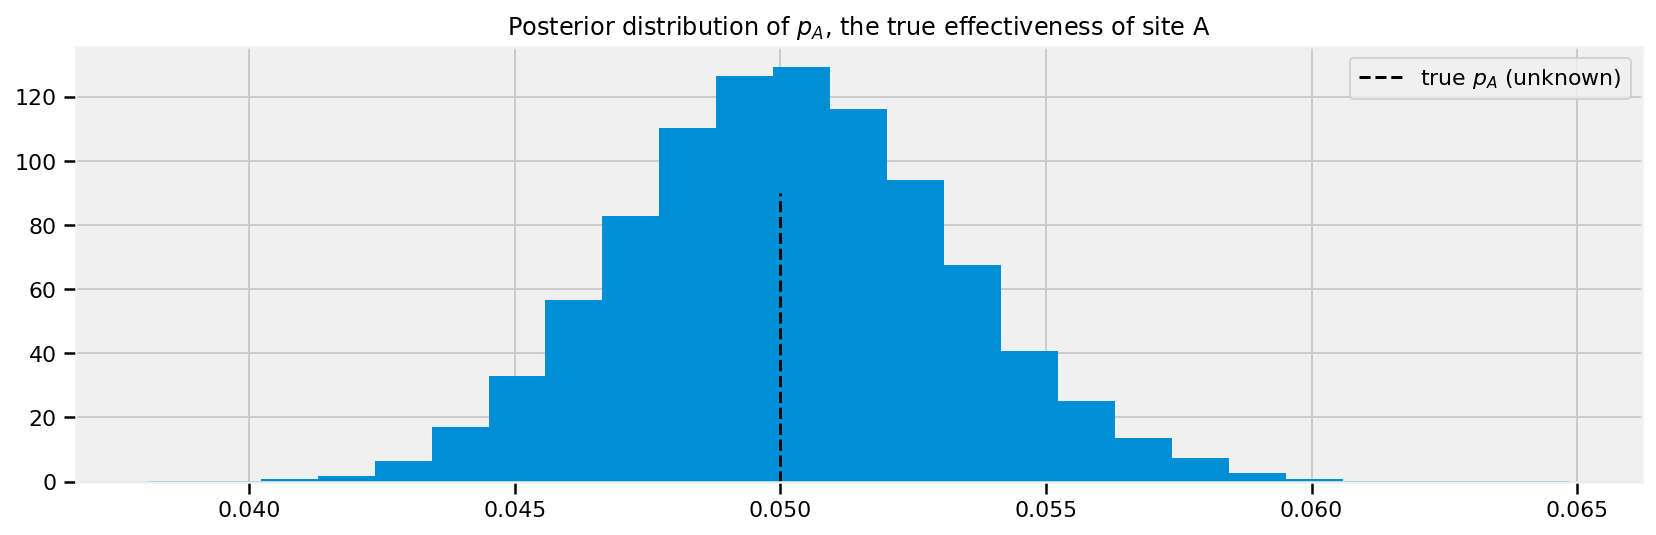

In [39]:
plt.figure(figsize(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(prob_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_prob_A_trace_, bins=25, histtype="stepfilled", normed=True)
plt.legend();

## A and B Together
A similar analysis can be done for site B's response data to determine the analogous $p_B$. But what we are really interested in is the difference between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$, and $\text{delta} = p_A - p_B$, all at once. We can do this using TFP's deterministic variables. (We'll assume for this exercise that $p_B = 0.04$, so $\text{delta} = 0.01$, $N_B = 750$ (significantly less than $N_A$) and we will simulate site B's data like we did for site A's data ). Our model now looks like the following:

$$\begin{align*}
p_A &\sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
p_B &\sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
X\ &\sim \text{Bernoulli}(\text{prob}=p) \\
\text{for }  i &= 1\ldots N: \\
 X_i\ &\sim \text{Bernoulli}(p_i)
\end{align*}$$

In [40]:
reset_sess()

#these two quantities are unknown to us.
true_prob_A_ = 0.05
true_prob_B_ = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A_ = 1500
N_B_ = 750

#generate some observations
observations_A = tfd.Bernoulli(name="obs_A", 
                          probs=true_prob_A_).sample(sample_shape=N_A_, seed=6.45)
observations_B = tfd.Bernoulli(name="obs_B", 
                          probs=true_prob_B_).sample(sample_shape=N_B_, seed=6.45)
[ 
    observations_A_,
    observations_B_,
] = evaluate([ 
    observations_A, 
    observations_B, 
])

print("Obs from Site A: ", observations_A_[:30], "...")
print("Observed Prob_A: ", np.mean(observations_A_), "...")
print("Obs from Site B: ", observations_B_[:30], "...")
print("Observed Prob_B: ", np.mean(observations_B_))

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Observed Prob_A:  0.050666666666666665 ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Observed Prob_B:  0.04


In [41]:
def delta(prob_A, prob_B):
    """
    Defining the deterministic delta function. This is our unknown of interest.
        
    Parameters
    ----------
      prob_A: scalar 
          estimate of the probability of a 1 appearing in observation set A
      prob_B: scalar 
          estimate of the probability of a 1 appearing in observation set B
    Returns
    -------
      Difference between prob_A and prob_B
    """
    return prob_A - prob_B

In [42]:
def double_joint_log_prob(observations_A, observations_B, 
                   prob_A, prob_B):
    """
    Joint log probability optimization function.
        
    Parameters
    ----------
      observations_A: An array of binary values representing the set of 
                      observations for site A
      observations_B: An array of binary values representing the set of 
                      observations for site B 
      prob_A: scalar estimate of the probability of a 1 appearing in 
                observation set A
      prob_B: scalar estimate of the probability of a 1 appearing in 
                observation set B 
    Returns
    -------
      Joint log probability optimization function.
    """
    tfd = tfp.distributions
  
    rv_prob_A = tfd.Uniform(low=0., high=1.)
    rv_prob_B = tfd.Uniform(low=0., high=1.)
  
    rv_obs_A = tfd.Bernoulli(probs=prob_A)
    rv_obs_B = tfd.Bernoulli(probs=prob_B)
  
    return (
        rv_prob_A.log_prob(prob_A)
        + rv_prob_B.log_prob(prob_B)
        + tf.reduce_sum(rv_obs_A.log_prob(observations_A))
        + tf.reduce_sum(rv_obs_B.log_prob(observations_B))
    )

In [43]:
number_of_steps = 37200 #@param {type:"slider", min:2000, max:50000, step:100}
#@markdown (Default is 18000).
burnin = 1000 #@param {type:"slider", min:0, max:30000, step:100}
#@markdown (Default is 1000).
leapfrog_steps=3 #@param {type:"slider", min:1, max:9, step:1}
#@markdown (Default is 6).


# Set the chain's start state.
initial_chain_state = [    
    tf.reduce_mean(tf.to_float(observations_A)) * tf.ones([], dtype=tf.float32, name="init_prob_A"),
    tf.reduce_mean(tf.to_float(observations_B)) * tf.ones([], dtype=tf.float32, name="init_prob_B")
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),   # Maps R to R.
    tfp.bijectors.Identity()    # Maps R to R.
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: double_joint_log_prob(observations_A, observations_B, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=3,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sample from the chain.
[
    posterior_prob_A,
    posterior_prob_B
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [44]:
evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_A_,
    posterior_prob_B_,
    kernel_results_
] = evaluate([
    posterior_prob_A,
    posterior_prob_B,
    kernel_results
])
    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))

burned_prob_A_trace_ = posterior_prob_A_[burnin:]
burned_prob_B_trace_ = posterior_prob_B_[burnin:]
burned_delta_trace_ = (posterior_prob_A_ - posterior_prob_B_)[burnin:]

acceptance rate: 0.6008064516129032


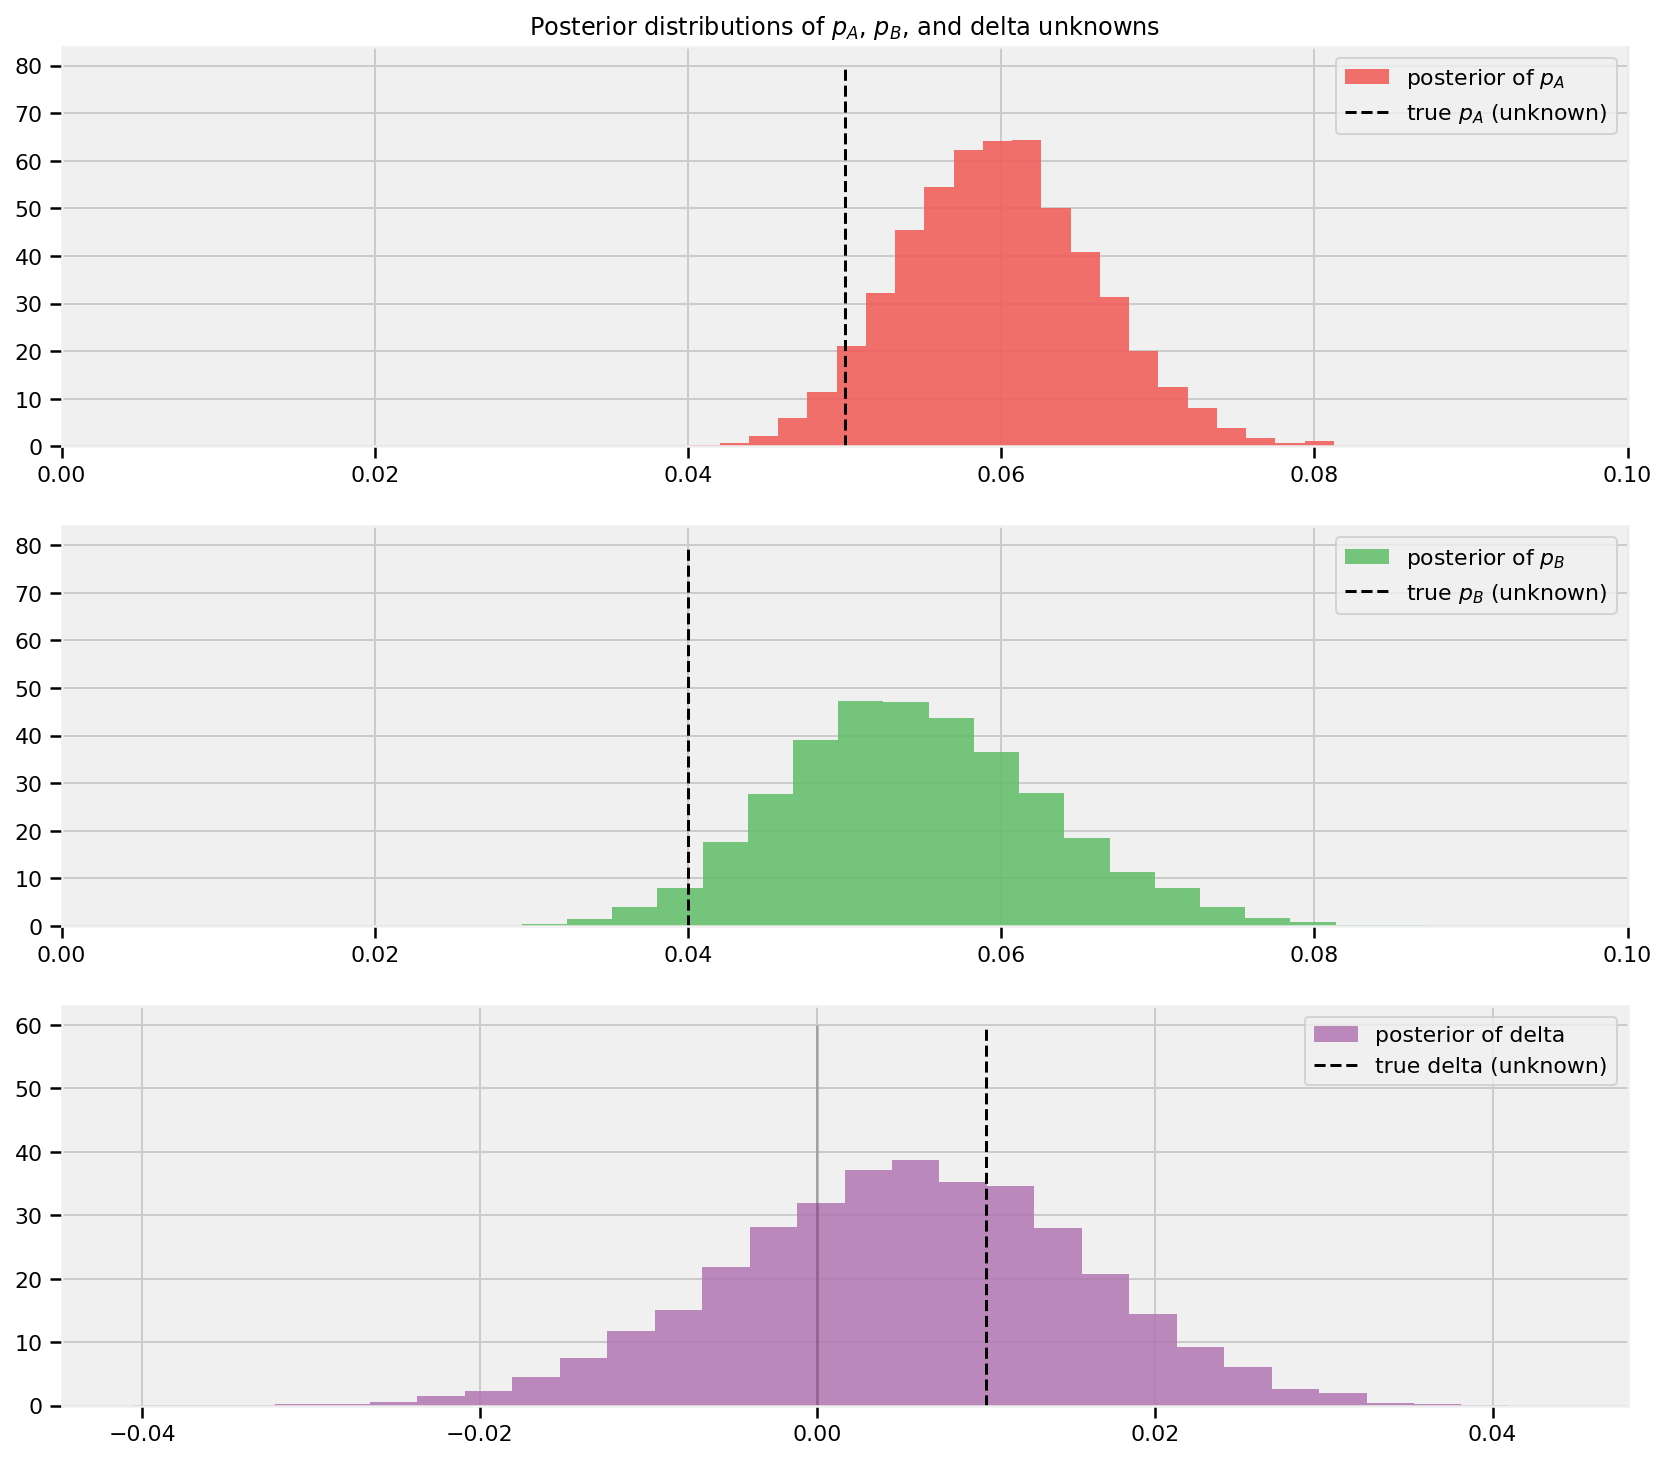

In [45]:
plt.figure(figsize(12.5, 12.5))

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(burned_prob_A_trace_, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color=TFColor[0], normed=True)
plt.vlines(true_prob_A_, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(burned_prob_B_trace_, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color=TFColor[2], normed=True)
plt.vlines(true_prob_B_, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(burned_delta_trace_, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color=TFColor[6], normed=True)
plt.vlines(true_prob_A_ - true_prob_B_, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [46]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(burned_delta_trace_ < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(burned_delta_trace_ > 0))

Probability site A is WORSE than site B: 0.300
Probability site A is BETTER than site B: 0.700


## An algorithm for human deceit
Social data has an additional layer of interest as people are not always honest with responses, which adds a further complication into inference. For example, simply asking individuals "Have you ever cheated on a test?" will surely contain some rate of dishonesty. What you can say for certain is that the true rate is less than your observed rate (assuming individuals lie only about not cheating; I cannot imagine one who would admit "Yes" to cheating when in fact they hadn't cheated).

To present an elegant solution to circumventing this dishonesty problem, and to demonstrate Bayesian modeling, we first need to introduce the binomial distribution.

### The Binomial Distribution
The binomial distribution is one of the most popular distributions, mostly because of its simplicity and usefulness. Unlike the other distributions we have encountered thus far in the book, the binomial distribution has 2 parameters: $N$, a positive integer representing $N$ trials or number of instances of potential events, and $p$, the probability of an event occurring in a single trial. Like the Poisson distribution, it is a discrete distribution, but unlike the Poisson distribution, it only weighs integers from $0$ to $N$. The mass distribution looks like:

$$P( X = k ) =  {{N}\choose{k}}  p^k(1-p)^{N-k}$$
If $X$ is a binomial random variable with parameters $p$ and $N$, denoted $X \sim \text{Bin}(N,p)$, then $X$ is the number of events that occurred in the $N$ trials (obviously $0 \le X \le N$). The larger $p$ is (while still remaining between 0 and 1), the more events are likely to occur. The expected value of a binomial is equal to $Np$. Below we plot the mass probability distribution for varying parameters.